Téléchargement des séries World Bank pour les années: [2023, 2024]
Chargement mapping pays->continent depuis: https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Countries%20Continents/Countries%20Continents.csv
Heuristique ISO3 échouée (optionnelle). Continuer sans iso3 fallback. Erreur: "['Region'] not in index"

Top 20 économies (PIB nominal 2024) — extrait:
 rank_2024 iso3                                              country     gdp_2024     gdp_2023  growth_23_24_pct     continent
       1.0  WLD                                                World 1.112530e+14 1.069392e+14          4.033830           NaN
       2.0  OED                                         OECD members 6.768705e+13 6.480350e+13          4.449685           NaN
       3.0  PST                            Post-demographic dividend 6.304064e+13 6.053884e+13          4.132545           NaN
       4.0  IBT                                     IDA & IBRD total 4.391812e+13 4.223276e+13          3.99064

/tmp/ipython-input-90186291.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top15, y="country", x="gdp_2024_billions", palette="deep")


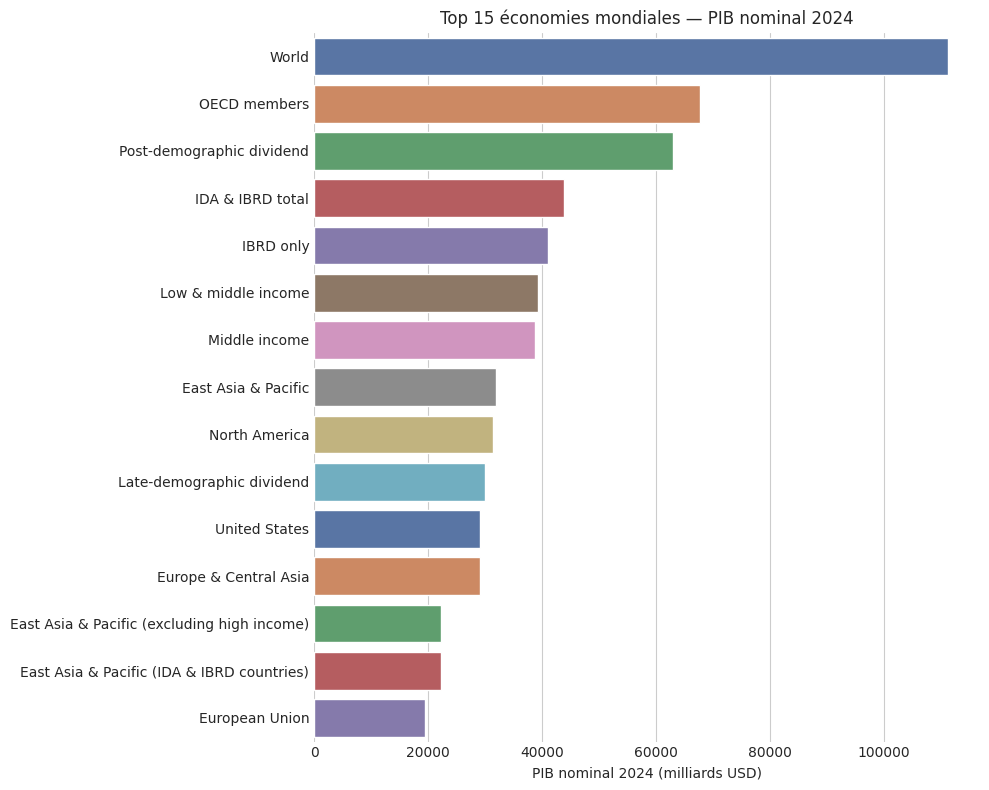

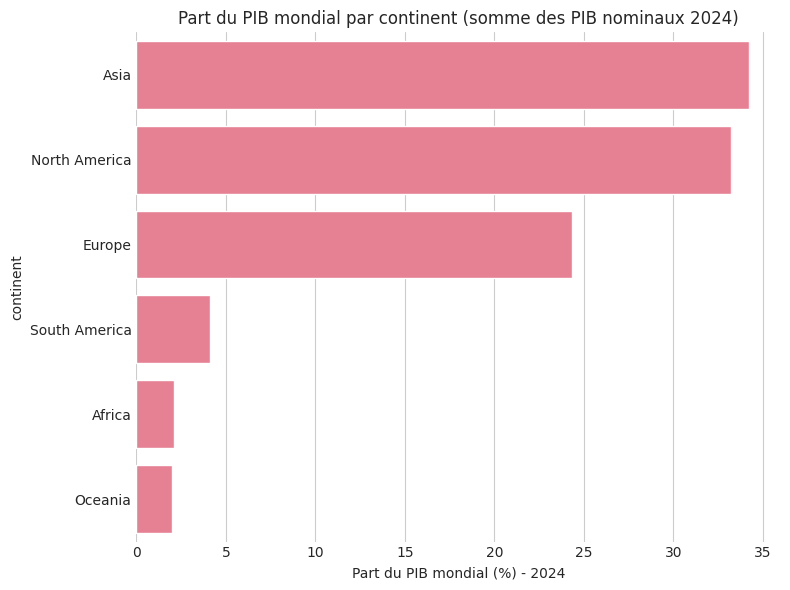

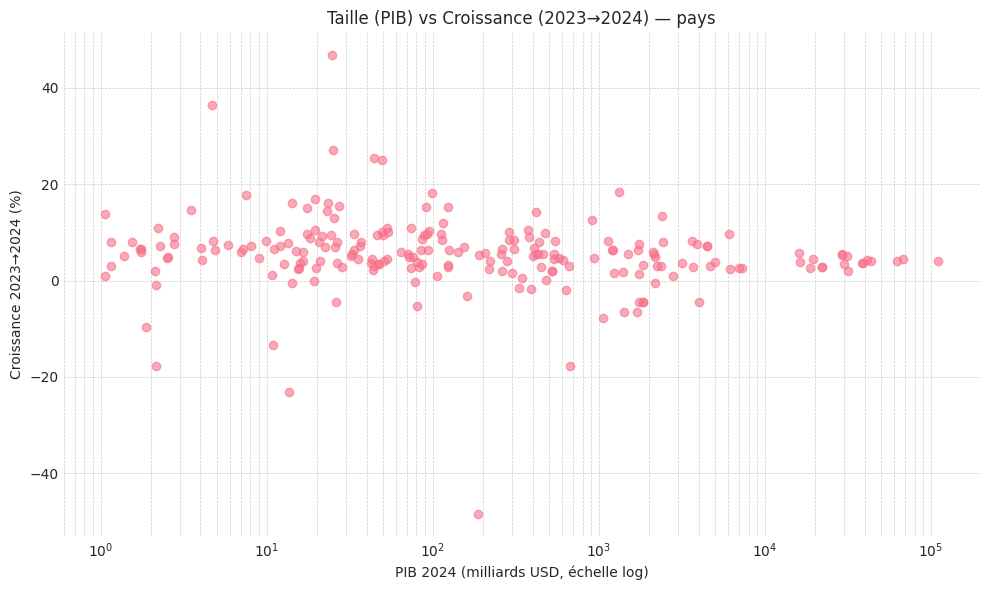


Fichiers exportés: top20_gdp_2024.csv, continent_aggregates_2024.csv, gdp_per_country_2023_2024.csv
Script terminé.


In [12]:
"""
Analyse du PIB nominal par pays (2024) — script complet.
Pré-requis: python >=3.8, pip install pandas requests matplotlib seaborn
(geopandas/plotly facultatifs si vous voulez des cartes interactives)
"""

import requests
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# ---------- Configuration ----------
WB_BASE = "http://api.worldbank.org/v2"
INDICATOR = "NY.GDP.MKTP.CD"   # GDP (current US$)
YEARS = [2023, 2024]           # années à récupérer pour croissance 2023->2024
PER_PAGE = 20000               # pour récupérer tout en une requête
# Mapping pays->continent CSV (raw GitHub / OWID dataset)
COUNTRY_CONTINENTS_CSV = (
    "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/"
    "Countries%20Continents/Countries%20Continents.csv"
)

# ---------- Helpers ----------
def fetch_worldbank_indicator(indicator: str, year: int) -> pd.DataFrame:
    """
    Récupère via l'API World Bank l'indicateur pour tous les pays pour une année donnée.
    Retour : DataFrame avec colonnes ['countryiso3code','country','value','date'].
    """
    url = f"{WB_BASE}/country/all/indicator/{indicator}"
    params = {"date": str(year), "format": "json", "per_page": PER_PAGE}
    resp = requests.get(url, params=params, timeout=30)
    resp.raise_for_status()
    data = resp.json()
    # data[1] contient les enregistrements si tout va bien
    records = data[1] if len(data) > 1 else []
    rows = []
    for r in records:
        country = r["country"]["value"]
        iso3 = r["countryiso3code"] or None
        val = r["value"]
        rows.append({"iso3": iso3, "country": country, "value": val, "year": year})
    df = pd.DataFrame(rows)
    return df

def load_continent_mapping(url: str) -> pd.DataFrame:
    """
    Charge un csv public qui contient associations pays->continent.
    Attendu: colonne 'Entity' (nom pays) et 'Continent' (ou similaire).
    Nous essayons d'accommoder différentes structures.
    """
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    txt = resp.text
    df = pd.read_csv(io.StringIO(txt))
    # Normalisation des colonnes communes
    cols = {c.lower(): c for c in df.columns}
    # Chercher une colonne contenant 'country'/'entity' et 'continent'
    country_col = None
    continent_col = None
    for k, v in cols.items():
        if "entity" in k or "country" in k or "name" in k:
            country_col = v
        if "continent" in k or "region" in k:
            continent_col = v
    if country_col is None:
        # fallback: première colonne
        country_col = df.columns[0]
    if continent_col is None:
        # fallback: essayer la 2ème colonne
        continent_col = df.columns[1] if len(df.columns) > 1 else None

    if continent_col is None:
        raise ValueError("Le fichier de mapping pays->continent ne contient pas de colonne 'continent' détectable")

    mapping = df[[country_col, continent_col]].rename(columns={country_col: "country", continent_col: "continent"})
    # nettoyage simple
    mapping["country"] = mapping["country"].str.strip()
    mapping["continent"] = mapping["continent"].str.strip()
    return mapping

# ---------- Récupération des données ----------
print("Téléchargement des séries World Bank pour les années:", YEARS)
dfs = []
for y in YEARS:
    dfi = fetch_worldbank_indicator(INDICATOR, y)
    dfs.append(dfi)
df_all = pd.concat(dfs, ignore_index=True)

print("Chargement mapping pays->continent depuis:", COUNTRY_CONTINENTS_CSV)
df_cont = load_continent_mapping(COUNTRY_CONTINENTS_CSV)

# ---------- Traitement ----------
# pivoter pour avoir colonnes 'gdp_2023', 'gdp_2024'
pivot = df_all.pivot_table(index=["iso3","country"], columns="year", values="value").reset_index()
pivot.columns.name = None
pivot = pivot.rename(columns={2023: "gdp_2023", 2024: "gdp_2024"})

# Joindre mapping. Note: les noms peuvent diverger — on essaie une jointure sur iso3 si disponible,
# sinon sur le nom pays (approx simple).
# Pour mapping with iso3 we need a mapping file that contains ISO codes; if not, use fuzzy join later.
# We'll first attempt join on country name.
merged = pivot.merge(df_cont, how="left", on="country")

# Si beaucoup de continents manquants, essayer heuristique: join via iso3 using a country-codes dataset
missing_cont = merged["continent"].isna().sum()
if missing_cont > 0:
    # tenter d'utiliser dataset 'datasets/country-codes' (GitHub raw) pour obtenir ISO3->name->continent
    try:
        cc_url = "https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv"
        cc = pd.read_csv(cc_url, low_memory=False)
        # sélectionner colonnes utiles
        if "ISO3166-1-Alpha-3" in cc.columns:
            cc_sub = cc[["ISO3166-1-Alpha-3", "CLDR display name", "Region"]].rename(
                columns={"ISO3166-1-Alpha-3":"iso3", "CLDR display name":"country_cc", "Region":"continent_cc"})
            merged = merged.merge(cc_sub, how="left", left_on="iso3", right_on="iso3")
            # si continent manquant, prendre continent_cc
            merged["continent"] = merged["continent"].fillna(merged["continent_cc"])
            merged = merged.drop(columns=["country_cc","continent_cc"])
    except Exception as e:
        print("Heuristique ISO3 échouée (optionnelle). Continuer sans iso3 fallback. Erreur:", e)

# Calculs additionnels
merged["gdp_2024"] = pd.to_numeric(merged["gdp_2024"], errors="coerce")
merged["gdp_2023"] = pd.to_numeric(merged["gdp_2023"], errors="coerce")
merged["growth_23_24_pct"] = (merged["gdp_2024"] / merged["gdp_2023"] - 1) * 100
# Remplacer inf/nan par None pour lisibilité
merged.loc[merged["gdp_2024"].isna(), "gdp_2024"] = None

# Rangs 2024 (desc)
merged["rank_2024"] = merged["gdp_2024"].rank(method="min", ascending=False)
merged_sorted = merged.sort_values(by="gdp_2024", ascending=False)

# ---------- Exemples de sorties ----------
TOP_N = 20
top = merged_sorted.head(TOP_N)[["rank_2024","iso3","country","gdp_2024","gdp_2023","growth_23_24_pct","continent"]]
print(f"\nTop {TOP_N} économies (PIB nominal 2024) — extrait:")
print(top.to_string(index=False))

# Pays émergents à forte croissance : critère exemple = croissance 2023->2024 >= 6% et PIB 2024 > 50 milliards
emerging = merged[
    (merged["growth_23_24_pct"].notna()) &
    (merged["growth_23_24_pct"] >= 6.0) &
    (merged["gdp_2024"].notna()) &
    (merged["gdp_2024"] >= 50e9)
].sort_values(by="growth_23_24_pct", ascending=False)

print("\nPays émergents (croissance >= 6% et PIB >= $50bn) — exemple:")
print(emerging[["country","iso3","continent","gdp_2024","growth_23_24_pct"]].to_string(index=False))

# ---------- Agrégation par continent ----------
agg_cont = merged.groupby("continent", dropna=True).agg(
    total_gdp_2024 = ("gdp_2024", "sum"),
    mean_growth = ("growth_23_24_pct", "mean"),
    countries = ("country", "count")
).reset_index().sort_values("total_gdp_2024", ascending=False)

print("\nAgrégat par continent (PIB 2024 total):")
print(agg_cont.to_string(index=False))

# ---------- Graphiques ----------
# Top 15 bar chart
top15 = merged_sorted.head(15).copy()
top15["gdp_2024_billions"] = top15["gdp_2024"] / 1e9

plt.figure(figsize=(10,8))
sns.barplot(data=top15, y="country", x="gdp_2024_billions", palette="deep")
plt.xlabel("PIB nominal 2024 (milliards USD)")
plt.ylabel("")
plt.title("Top 15 économies mondiales — PIB nominal 2024")
plt.tight_layout()
plt.show()

# Continents: part de marché global
agg_cont = agg_cont.dropna(subset=["total_gdp_2024"])
agg_cont["share_pct"] = agg_cont["total_gdp_2024"] / agg_cont["total_gdp_2024"].sum() * 100

plt.figure(figsize=(8,6))
sns.barplot(data=agg_cont.sort_values("share_pct", ascending=False), x="share_pct", y="continent")
plt.xlabel("Part du PIB mondial (%) - 2024")
plt.title("Part du PIB mondial par continent (somme des PIB nominaux 2024)")
plt.tight_layout()
plt.show()

# Scatter GDP size vs growth
plt.figure(figsize=(10,6))
scatter = merged.dropna(subset=["gdp_2024","growth_23_24_pct"]).copy()
scatter["gdp_2024_bil"] = scatter["gdp_2024"]/1e9
# limiter points pour lisibilité
scatter_plot = scatter[(scatter["gdp_2024_bil"]>1) & (scatter["growth_23_24_pct"].abs() < 100)]
plt.scatter(scatter_plot["gdp_2024_bil"], scatter_plot["growth_23_24_pct"], alpha=0.6)
plt.xscale("log")
plt.xlabel("PIB 2024 (milliards USD, échelle log)")
plt.ylabel("Croissance 2023→2024 (%)")
plt.title("Taille (PIB) vs Croissance (2023→2024) — pays")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# ---------- Exports (optionnel) ----------
top.to_csv("top20_gdp_2024.csv", index=False)
agg_cont.to_csv("continent_aggregates_2024.csv", index=False)
merged.to_csv("gdp_per_country_2023_2024.csv", index=False)

print("\nFichiers exportés: top20_gdp_2024.csv, continent_aggregates_2024.csv, gdp_per_country_2023_2024.csv")
print("Script terminé.")
